In [1]:
import numpy as np
import pandas as pd
import main
las_data = pd.read_csv(main.csv_las_out_full_path, delimiter=';')
las_data.head()

,well_name,STRT,STOP,DEPT,aps,rp,kp,kgl,kpr,kvo,kng,lit,satur,UWI
0,224st4,2729.2,2929.4,2729.2,0.22,8.4,0.095,0.329,0.1,1.0,0.0,0.0,0.0,314_103ST2
1,224st4,2729.2,2929.4,2729.3,0.22,8.4,0.095,0.329,0.1,1.0,0.0,0.0,0.0,314_103ST2
2,224st4,2729.2,2929.4,2729.4,0.22,8.4,0.095,0.329,0.1,1.0,0.0,0.0,0.0,314_103ST2
3,224st4,2729.2,2929.4,2729.5,0.22,8.4,0.095,0.329,0.1,1.0,0.0,0.0,0.0,314_103ST2
4,224st4,2729.2,2929.4,2729.6,0.22,8.4,0.095,0.329,0.1,1.0,0.0,0.0,0.0,314_103ST2


In [2]:
del las_data['STRT']
del las_data['STOP']
del las_data['rp']
del las_data['kgl']
del las_data['kpr']
del las_data['kvo']
del las_data['kng']
del las_data['lit']
del las_data['satur']
del las_data['kp']
las_data.head()

,well_name,DEPT,aps,UWI
0,224st4,2729.2,0.22,314_103ST2
1,224st4,2729.3,0.22,314_103ST2
2,224st4,2729.4,0.22,314_103ST2
3,224st4,2729.5,0.22,314_103ST2
4,224st4,2729.6,0.22,314_103ST2


In [3]:
las_data.replace('314_', '', regex=True, inplace=True)
#del las_data['well_name']
las_data = las_data.rename(columns={'well_name': 'WELL_NAME'})
las_data = las_data.rename(columns={'UWI': 'WELL_NAME_UWI'})
las_data = las_data.rename(columns={'aps': 'APS'})
las_data = las_data.rename(columns={'DEPT': 'DEPTH'})
las_data.head(n=2)

,WELL_NAME,DEPTH,APS,WELL_NAME_UWI
0,224st4,2729.2,0.22,103ST2
1,224st4,2729.3,0.22,103ST2


In [4]:
real_top = pd.read_csv('real_data_test\\top_df.csv', delimiter=';')
real_top = real_top.rename(columns={'WELL_NAME': 'WELL_NAME_UWI'})
del real_top['X']
del real_top['Y']
real_top.head(n=2)

,WELL_NAME_UWI,DEPTH_TOP
0,100,2548.81
1,101,2556.23


In [5]:
real_bottom = pd.read_csv('real_data_test\\bottom_df.csv', delimiter=';')
real_bottom = real_bottom.rename(columns={'WELL_NAME': 'WELL_NAME_UWI'})
del real_bottom['X']
del real_bottom['Y']
real_bottom.head(n=2)

,WELL_NAME_UWI,DEPTH_BOTTOM
0,100,2564.81
1,101,2571.71


In [6]:
# данные от организаторов
water_content_data = pd.read_csv(main.data_dir + "\\water_content.csv", delimiter=';')
water_content_data = water_content_data.rename(columns={'Скважина': main.keys_dict[main.kid_well]})
water_content_data = water_content_data.rename(columns={' Начальная обводненность ': 'WC'})
water_content_data = water_content_data.rename(columns={'Дата запуска': 'date_start'})
del water_content_data['date_start']
water_content_data = water_content_data.rename(columns={'well_name': 'WELL_NAME'})
water_content_data.head(n=5)

,WELL_NAME,WC
0,380,0.49
1,379,0.30
2,370,0.13
3,417,0.08
4,389,0.22


In [7]:
# данные посчитанные на карте
wc_calc_data = pd.read_csv('fake_data\\map_wc_test_calc_res.csv', delimiter=';')
del wc_calc_data['Y']
del wc_calc_data['X']
wc_calc_data['WELL_NAME'] = wc_calc_data['WELL_NAME'].astype('str')
wc_calc_data = wc_calc_data.drop(wc_calc_data[wc_calc_data['WC'] > 1].index)
wc_calc_data.head()

,WELL_NAME,WC
0,380,0.392981
1,379,0.286590
2,370,0.231697
3,417,0.195822
4,389,0.277036


In [8]:
wc_calc_data = wc_calc_data.rename(columns={'WC': 'WC_CALC'})

In [9]:
print(len(las_data['WELL_NAME'].value_counts()))
print(len(real_bottom['WELL_NAME_UWI'].value_counts()))
print(len(real_top['WELL_NAME_UWI'].value_counts()))
print(len(water_content_data['WELL_NAME'].value_counts()))
print(len(wc_calc_data['WELL_NAME'].value_counts()))

223
230
230
180
164


In [10]:
wc_calc_data =pd.merge(wc_calc_data, water_content_data, on='WELL_NAME')

In [11]:
wc_calc_data.head()

,WELL_NAME,WC_CALC,WC
0,380,0.392981,0.49
1,379,0.286590,0.30
2,370,0.231697,0.13
3,417,0.195822,0.08
4,389,0.277036,0.22


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

def data_analize_func(predict_for_analize, file_name = ''):
    # подготовка данных
    data_for_analize = predict_for_analize.sort_values(by=['y_hold'])
    data_for_analize['x_axis'] = [x for x in range(len(predict_for_analize['y_hold']))]
    data_for_analize.head()
    if file_name != '':
        data_for_analize.to_csv('AllGisParams/' + file_name, index=False, sep = ';')
    
    # построение графиков
    plt.scatter(data_for_analize['x_axis'], data_for_analize['y_predict'], color = 'blue')
    plt.scatter(data_for_analize['x_axis'], data_for_analize['y_hold'], color = 'red')
    plt.show()
    
    # regression metrics
    print('MSE                      = '+ str(mean_squared_error(data_for_analize['y_hold'], 
                                                                data_for_analize['y_predict'])))
    print('MAE                      = '+ str(mean_absolute_error(data_for_analize['y_hold'], 
                                                                 data_for_analize['y_predict'])))
    print('r2_score                 = '+ str(r2_score(data_for_analize['y_hold'], 
                                                      data_for_analize['y_predict'])) + '    (best_value is 1)')
    print('explained_variance_score = '+ str(explained_variance_score(data_for_analize['y_hold'], 
                                                                      data_for_analize['y_predict'])) + '    (best_value is 1)')

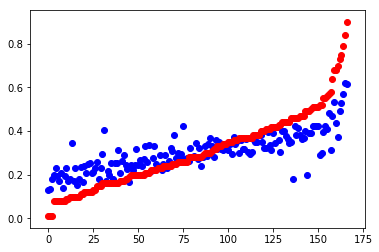

MSE                      = 0.0111287426546
MAE                      = 0.0812993892216
r2_score                 = 0.621206347009    (best_value is 1)
explained_variance_score = 0.621399026332    (best_value is 1)


In [13]:
wc_analize = wc_calc_data[['WC', 'WC_CALC']]

wc_analize = wc_analize.rename(columns={'WC': 'y_hold', 'WC_CALC': 'y_predict'})

data_analize_func(wc_analize)

In [14]:
wc_analize.describe()

,y_hold,y_predict
count,167.000000,167.000000
mean,0.309102,0.306723
std,0.171920,0.090456
min,0.010000,0.129652
25%,0.170000,0.241901
50%,0.280000,0.304484
75%,0.420000,0.361629
max,0.900000,0.622246


In [15]:
#real_data = pd.merge(water_content_data, las_data, on='WELL_NAME')
real_data = pd.merge(wc_calc_data, las_data, on='WELL_NAME')
real_data = pd.merge(real_data, real_top, on='WELL_NAME_UWI')
real_data = pd.merge(real_data, real_bottom, on='WELL_NAME_UWI') 
real_data.head()

,WELL_NAME,WC_CALC,WC,DEPTH,APS,WELL_NAME_UWI,DEPTH_TOP,DEPTH_BOTTOM
0,380,0.392981,0.49,2593.0,0.01,178,2560.32,2586.48
1,380,0.392981,0.49,2593.1,0.01,178,2560.32,2586.48
2,380,0.392981,0.49,2593.2,0.01,178,2560.32,2586.48
3,380,0.392981,0.49,2593.3,0.01,178,2560.32,2586.48
4,380,0.392981,0.49,2593.4,0.01,178,2560.32,2586.48


In [16]:
print(len(real_data['WELL_NAME'].value_counts()))
real_data.info()

164
<class 'pandas.core.frame.DataFrame'>
Int64Index: 341815 entries, 0 to 341814
Data columns (total 8 columns):
WELL_NAME        341815 non-null object
WC_CALC          341815 non-null float64
WC               341815 non-null float64
DEPTH            341815 non-null float64
APS              149205 non-null float64
WELL_NAME_UWI    341815 non-null object
DEPTH_TOP        341815 non-null float64
DEPTH_BOTTOM     339886 non-null float64
dtypes: float64(6), object(2)
memory usage: 23.5+ MB


In [17]:
real_data_na = real_data.dropna()
print(len(real_data['WELL_NAME'].value_counts()))
real_data.info()

164
<class 'pandas.core.frame.DataFrame'>
Int64Index: 341815 entries, 0 to 341814
Data columns (total 8 columns):
WELL_NAME        341815 non-null object
WC_CALC          341815 non-null float64
WC               341815 non-null float64
DEPTH            341815 non-null float64
APS              149205 non-null float64
WELL_NAME_UWI    341815 non-null object
DEPTH_TOP        341815 non-null float64
DEPTH_BOTTOM     339886 non-null float64
dtypes: float64(6), object(2)
memory usage: 23.5+ MB


In [18]:
import lasio
import re
def load_and_convert_to_interp(dev_path, well_name):
    f = open(dev_path + well_name + '.dev', 'r')
    well_num = 0
    md = []
    abs = []
    for line in f.readlines():
        if well_num > 16:
            # list = line.split(' ')
            # print(list)
            numbers = re.findall(r'[-]?[0-9]+.[0-9]+', line)
            md.append(float(numbers[0]))
            abs.append(float(numbers[3]))
        well_num = well_num +1
    f.close()
    f_spline = interpolate.interp1d(abs, md, kind = 'slinear', bounds_error=False)
    return f_spline

Загружаем переход от md в abs

In [20]:
from scipy import interpolate
dev_path = "..\\tasks\\task 6\\data\\trace\\"
well_name_list = real_data_na['WELL_NAME_UWI'].value_counts().index.tolist()
well_name = well_name_list[0]
f_spline = load_and_convert_to_interp(dev_path, well_name)
print(f_spline(0))

107.8


In [24]:
from scipy import interpolate
well_name_list = real_data_na['WELL_NAME_UWI'].value_counts().index.tolist()
x_values = []
y_values = []
y_values_calc = []
count_val = 100
well_count = 0
for well_name in well_name_list:
    if well_count%20 == 0:
        print(well_count, ' of ', len(well_name_list))
    data_well =  real_data_na[real_data_na['WELL_NAME_UWI'] == well_name]
    f_spline = load_and_convert_to_interp(dev_path, well_name)
    bottom = f_spline(data_well['DEPTH_BOTTOM'].tolist()[0])
    top = f_spline(data_well['DEPTH_TOP'].tolist()[0])
    data_well_by_bound = data_well[(data_well['DEPTH'] >= top) & (data_well['DEPTH'] <= bottom)]
    x_arr = data_well_by_bound['DEPTH']
    y_arr = data_well_by_bound['APS']
    
    # print ('length of array depth', len(x_arr))
    # print(len(x_arr), len(y_arr))
    if len(x_arr) < 10:
        continue
    f_spline = interpolate.interp1d(x_arr, y_arr, kind = 'slinear')
    h_start = data_well_by_bound['DEPTH'].min()
    h_end = data_well_by_bound['DEPTH'].max()
    # print(h_start, h_end, top, bottom)
    h_step = (h_end - h_start)/count_val
    x_temp = []
    i = 0
    while(i < count_val):
        x_temp.append(float(f_spline(h_start + i * h_step)))
        i = i + 1
    x_values.append(x_temp)  
    y_values.append(data_well['WC'].tolist()[0])
    y_values_calc.append(data_well['WC_CALC'].tolist()[0])
    well_count = well_count + 1
print('end fill')

0  of  135
20  of  135
40  of  135
60  of  135
80  of  135
100  of  135
120  of  135
end fill


In [28]:
print(len(y_values))
print(len(y_values_calc))

129
129


In [31]:
save_x = pd.DataFrame(x_values, columns=['aps' + str(z) for z in range(0, len(x_values[0]))])
save_y_wc_real = pd.DataFrame(y_values, columns=['wc'])
save_y_wc_calc = pd.DataFrame(y_values_calc, columns=['wc'])

save_xy_real = pd.merge(save_y_wc_real, save_x, left_index = True, right_index = True)
save_xy_real.to_csv('fake_data/_aps_real_wc.csv', sep = ';', index = False)

save_xy_calc = pd.merge(save_y_wc_calc, save_x, left_index = True, right_index = True)
save_xy_calc.to_csv('fake_data/_aps_calc_wc.csv', sep = ';', index = False)

In [ ]:
y_values_r = [int(10 * y_val) for y_val in y_values]

In [ ]:
import pickle
# Loading the saved decision tree model pickle
decision_tree_pkl_filename = 'fake_data\\decision_forest_grid_fake_data.pkl'
decision_tree_model_pkl_load = open(decision_tree_pkl_filename, 'rb')
decision_tree_model = pickle.load(decision_tree_model_pkl_load)
print("Loaded Decision tree model :: ", decision_tree_model)
# tree_pred = decision_tree_model.predict(x_hold)
# accuracy_score(y_hold, tree_pred)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
tree_pred = decision_tree_model.predict(x_values)
accuracy_score(y_values_r, tree_pred)

In [ ]:
import pickle
# Loading the saved decision tree model pickle
decision_gbt_pkl_filename = 'fake_data\\decision_gbt_grid_fake_data.pkl'
decision_gbt_model_pkl_load = open(decision_gbt_pkl_filename, 'rb')
decision_gbt_model = pickle.load(decision_gbt_model_pkl_load)
print("Loaded Decision model :: ", decision_tree_model)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
gbt_pred = decision_gbt_model.predict(x_values)
accuracy_score(y_values_r, gbt_pred)

In [ ]:
count = 0
for y_r, y_c in zip(y_values_r, tree_pred):
    if (abs(y_c-y_r) == 0):
        count = count + 1
    # print(y_r - y_c)
print('count = ', count, 'of ', len(y_values_r))